In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme("paper")
sns.set_style("whitegrid")

In [5]:
import os

DATA_DIR = "/home/julian/Uni/MasterThesis/data/"

corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_POSTQC.h5ad"))

In [5]:
import sys

print(type(corona_ann.X))
print(corona_ann.X.dtype)

# since float32 are used in np - one number requires 4 bytes
n_bytes_per_count = 4
print("%f.2 GB object (sparse)"  % (int(sys.getsizeof(corona_ann)) / 1000000000))
print("%f.2 GB raw matrix" % (corona_ann.shape[0] * corona_ann.shape[1] * n_bytes_per_count / 1000000000))
corona_ann

<class 'scipy.sparse._csr.csr_matrix'>
float32
5.438284.2 GB object (sparse)
42.404290.2 GB raw matrix


AnnData object with n_obs × n_vars = 491473 × 21570
    obs: 'patientID', 'sampleID', 'cohort', 'timepoint', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_mito', 'pct_counts_ribo', 'pct_counts_hb'

In [6]:
corona_ann.obs.timepoint = pd.Categorical(corona_ann.obs.timepoint, 
                                          categories=["t1","t2", "t3", "t4", "d1", "d28", "d56", "M6"], 
                                          ordered=True)

/tmp/ipykernel_111528/1253566294.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_b_samples_by_timepoint = corona_ann[corona_ann.obs.cohort == "B"].obs.copy().groupby(["timepoint"])["patientID"].agg(["nunique"]).reset_index()
/tmp/ipykernel_111528/1253566294.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_p_samples_by_timepoint = corona_ann[corona_ann.obs.cohort == "P"].obs.copy().groupby(["timepoint"])["patientID"].agg(["nunique"]).reset_index()


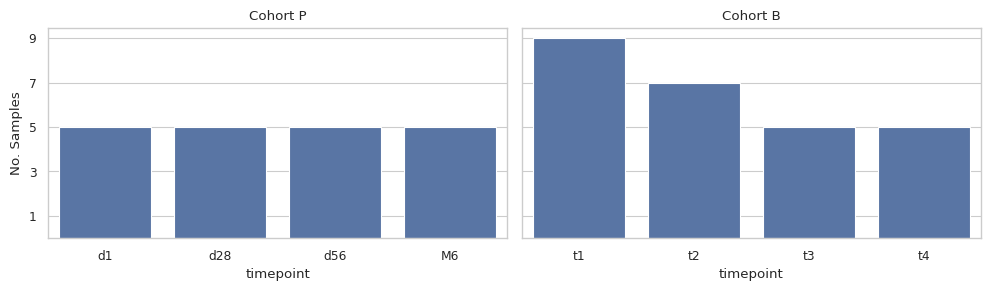

In [9]:
cohort_b_samples_by_timepoint = corona_ann[corona_ann.obs.cohort == "B"].obs.copy().groupby(["timepoint"])["patientID"].agg(["nunique"]).reset_index()
cohort_p_samples_by_timepoint = corona_ann[corona_ann.obs.cohort == "P"].obs.copy().groupby(["timepoint"])["patientID"].agg(["nunique"]).reset_index()

fig, (a1, a2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3), sharey=True)

sns.barplot(cohort_p_samples_by_timepoint, x="timepoint", y="nunique", ax=a1)
sns.barplot(cohort_b_samples_by_timepoint, x="timepoint", y="nunique", ax=a2)

a1.set_title("Cohort P")
a2.set_title("Cohort B")
a2.set_ylabel("")
a1.set_ylabel("No. Samples")

a1.set_yticks([1,3,5,7,9])
fig.tight_layout()
fig.savefig("num_samples_by_timepoint.png")

**How many patients?**

In [9]:
corona_ann.obs.patientID.unique().size

14

In [82]:
corona_ann.obs.patientID.unique().to_numpy()

array(['B12', 'P16', 'P8', 'B4', 'B9', 'P6', 'B6', 'B10', 'B13', 'B3',
       'P7', 'B2', 'P4', 'B1'], dtype=object)

**What are the cohorts referring to?**
Cohort B contains the `t*` timepoints, cohort P `d1, d28, d56, M6`

## Is the data logarithmized yet?

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


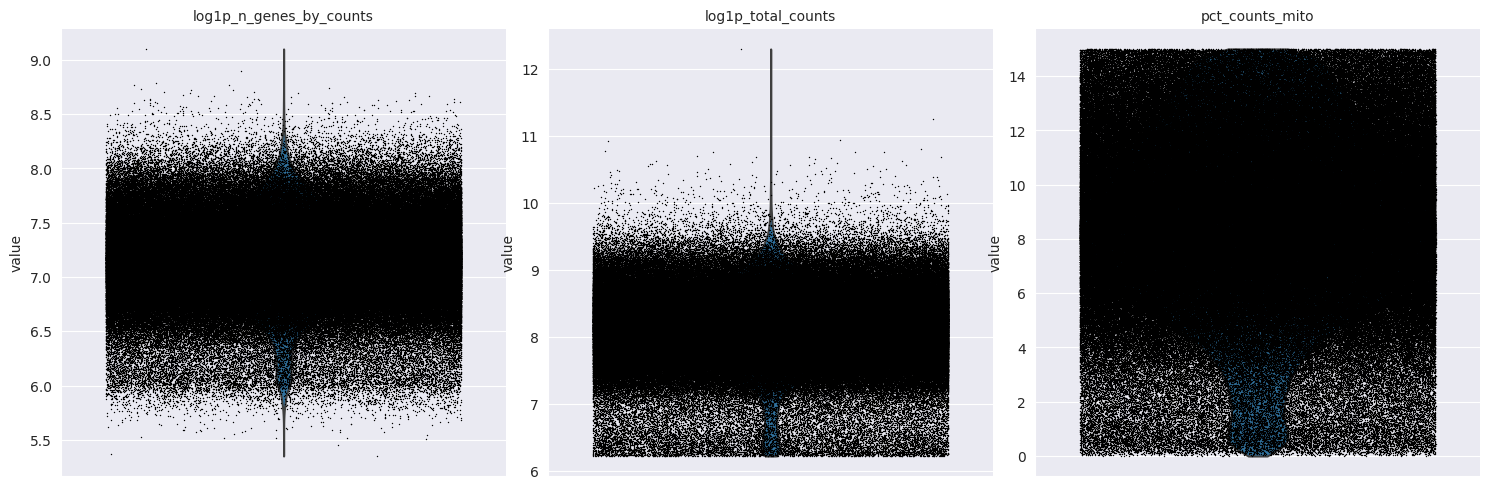

In [11]:
# Those values are already computed: 
sc.pl.violin(corona_ann, ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mito'],
             jitter=0.4, multi_panel=True)

In [34]:
# annotate the group of mitochondrial genes as 'mt'
corona_ann.var['mt'] = corona_ann.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# recalculate the included QC metrics 
(obs, var) = sc.pp.calculate_qc_metrics(corona_ann, qc_vars=['mt'], percent_top=None, log1p=True, inplace=False)

# create copy
copy = corona_ann.copy()
copy.obs = obs
copy.var = var

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


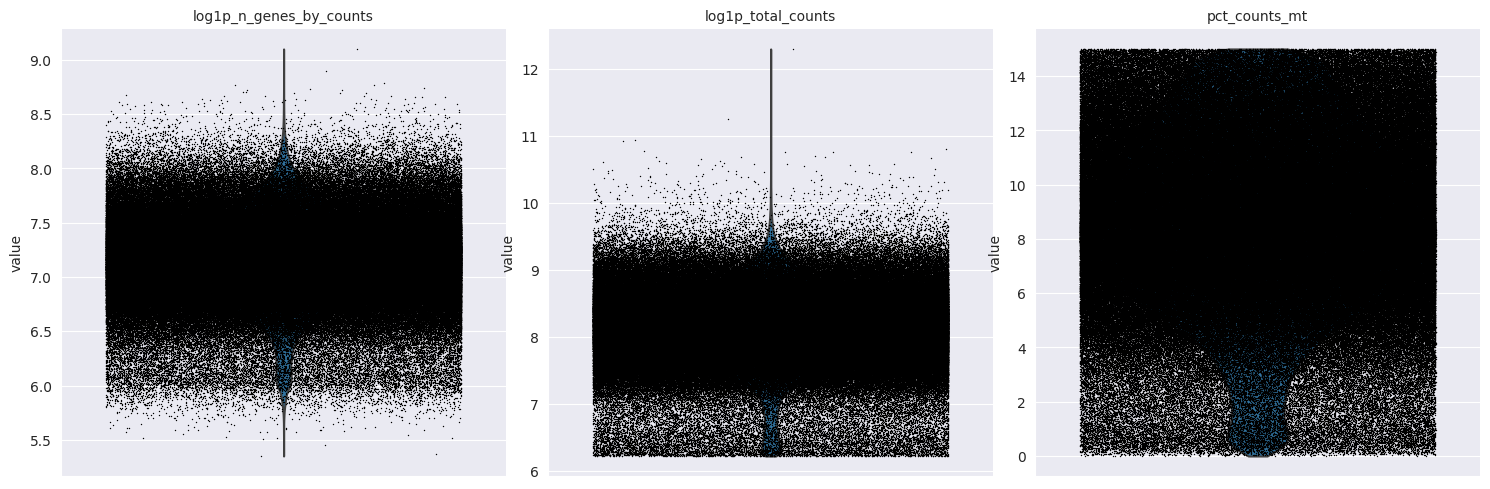

In [35]:
# plot again
sc.pl.violin(copy, ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

**Above plots can be reproduced. Very high percentage of mitochondrial genes in a lot of Cells!**

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):
_High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane._

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


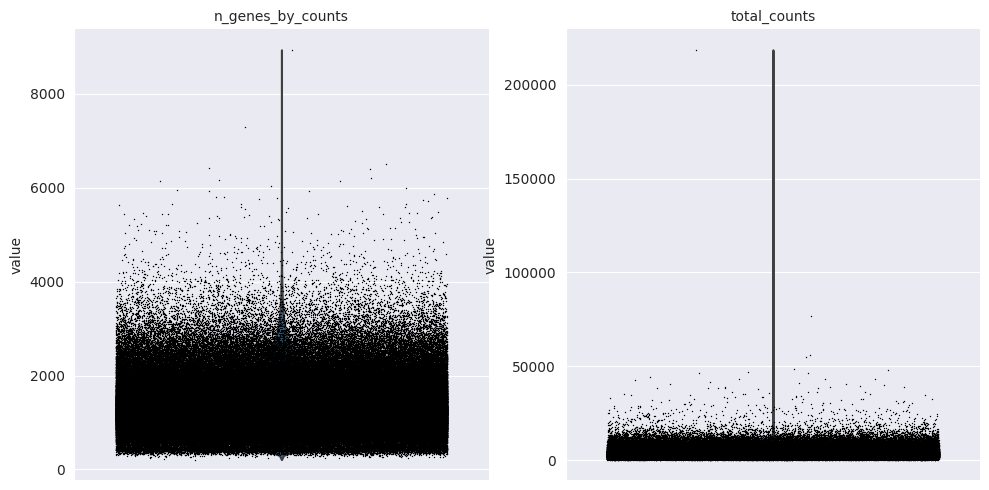

In [36]:
# recalculate the included QC metrics 
(obs, var) = sc.pp.calculate_qc_metrics(corona_ann, percent_top=None, log1p=False, inplace=False)

# create copy
copy = corona_ann.copy()
copy.obs = obs
copy.var = var
sc.pl.violin(copy, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

**Data does not look logarithmized**

## Was CD4 filtered out in preprocessing?

In [38]:
corona_ann.var_names[corona_ann.var_names.str.startswith("CD4")]

Index(['CD48', 'CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')

**Yep...**

In [46]:
import scanpy as sc
copy = corona_ann.copy()
sc.pp.filter_genes(corona_ann, min_cells=3, inplace=True)
print(copy.var_names[copy.var_names.str.startswith("CD4")])

Index(['CD48', 'CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')


In [47]:
copy = copy[copy.obs.n_genes_by_counts < 5500, :]
print(copy.var_names[copy.var_names.str.startswith("CD4")])

Index(['CD48', 'CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')


In [48]:
copy = copy[copy.obs.pct_counts_mito < 10, :]
print(copy.var_names[copy.var_names.str.startswith("CD4")])

Index(['CD48', 'CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')


In [49]:
# normalize
sc.pp.normalize_total(copy)
print(copy.var_names[copy.var_names.str.startswith("CD4")])

# log transform
sc.pp.log1p(copy)
print(copy.var_names[copy.var_names.str.startswith("CD4")])

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Index(['CD48', 'CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')
Index(['CD48', 'CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')


In [66]:
sc.pp.highly_variable_genes(copy, min_mean=0.0125, max_mean=3, min_disp=-0.5)
print(copy.var_names[copy.var.highly_variable &  copy.var_names.str.startswith("CD4")])
print(sum(copy.var.highly_variable))

Index(['CD46', 'CD47', 'CD44', 'CD4', 'CD40', 'CD40LG'], dtype='object')
8745


**CD4 is not variable due to the min_disp cutoff. For CD4 to be included, min_disp needs to -0.1 or lower**

### Are all marker genes in the original dataset?

In [68]:
markers_nouri23 = ["CD3D", 
                   "IL7R",
                   "CD8A", "CD8B", "NKG7", "GNLY", "KLRF1",
                   "CD79A", "MS4A1", "CD19", "JCHAIN",
                   "CD4",
                   "MS4A7", 
                   "VCAN", "CD14", "FCN1", "LYZ", 
                   "PPBP", "PF4", 
                   "CD34", "CD133",
                   "SPINK2",
                   "HBB", "HBA1", "HBA2", 
                   "S100A8", "S100A9", "IFITM2", 
                   "FCGR3A",
                   "KLRB1", "CD38"
                  ]

In [72]:
print(len(markers_nouri23))
print(len(set(corona_ann.var_names).intersection(set(markers_nouri23))))
print(set(markers_nouri23) - set(corona_ann.var_names))

31
30
{'CD133'}


In [79]:
### B-cell markers contained?


In [118]:
corona_ann.var_names[corona_ann.var_names == "FCGR3A"]

Index(['FCGR3A'], dtype='object')

### Why are some markers expressed so low?

In [88]:
corona_processed = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_preprocessed.h5ad"))

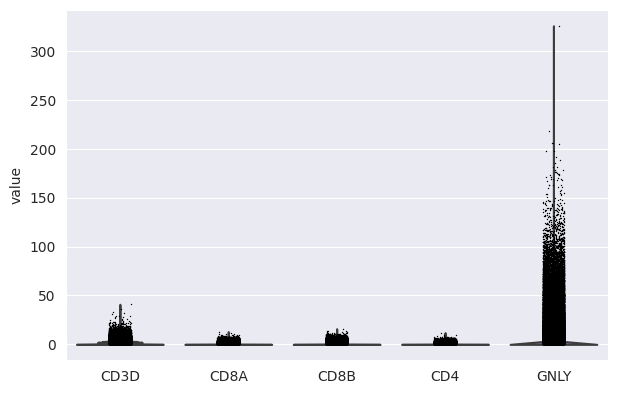

In [92]:
sc.pl.violin(corona_processed, ["CD3D", "CD8A", "CD8B", "CD4", "GNLY"], use_raw=False, layer="counts")

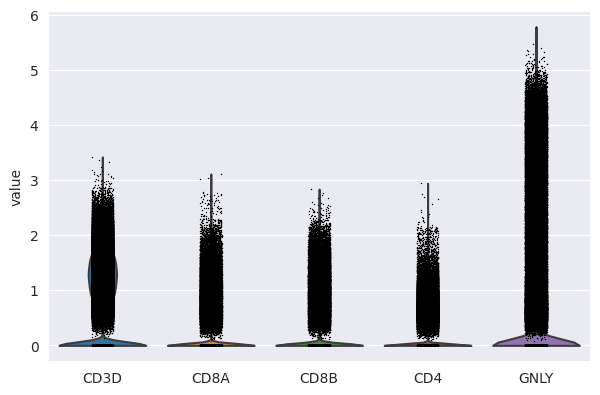

In [93]:
sc.pl.violin(corona_processed, ["CD3D", "CD8A", "CD8B", "CD4", "GNLY"], use_raw=False, layer="lognorm_counts")


## Why doesn't UMAP separate T-Cels nicely?

In [120]:
import datetime
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

In [131]:
import os
DATA_DIR = "/home/ubuntu/data"
corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_preprocessed.h5ad"))
corona_ann.raw = corona_ann

In [132]:
corona_sub = corona_ann[corona_ann.obs.cohort == "P", :].copy()

In [145]:
corona_sub.X = np.array(corona_sub.X.todense())

In [ ]:
start = datetime.datetime.now()
sc.pp.neighbors(corona_sub, use_rep="X")
sc.tl.umap(corona_sub)
print(datetime.datetime.now() - start)

In [ ]:
sc.pl.umap(corona_sub, components="1,2", color=["cohort", "patientID", "timepoint"])

In [ ]:
sc.pl.umap(corona_ann, color=["CD3D", "CD4", "MS4A1", "CD8A", "CD8B", "NKG7"], vmax=20)

## Try t-SNE instead